$\textbf{LIBRARIES}$

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style("darkgrid")

In [4]:
def sep_print(): print('='*100)

In [5]:
path = "../Data/"

Quick look into data

In [6]:
df_states = pd.read_csv(path + 'stations_info.csv')
print(df_states.columns)

sep_print()
print(df_states.head(2))

Index(['file_name', 'state', 'city', 'agency', 'station_location',
       'start_month', 'start_month_num', 'start_year'],
      dtype='object')
  file_name           state        city agency          station_location  \
0     AP001  Andhra Pradesh    Tirupati  APPCB       Tirumala, Tirupati    
1     AP002  Andhra Pradesh  Vijayawada  APPCB  PWD Grounds, Vijayawada    

  start_month  start_month_num  start_year  
0        July                7        2016  
1         May                5        2017  


I have a lot of data, so we're going to choose only one state for analysis. 
I'm looking for the state that has the minimum number of agencies (since each agency can have different measurements or column names for the same feature, choosing one will be easier), the most data available, and a similar number of columns.

In [7]:
sum_dict = dict()
max_dict = dict()
min_dict = dict()

for i in os.listdir(path):

    if not i.endswith(".csv"):
        next

    prefix = i[:2]
    val = pd.read_csv(path + i, nrows= 1).shape[1]

    if prefix in sum_dict:
            sum_dict[prefix] += val
            max_dict[prefix] = val if max_dict[prefix] < val else  max_dict[prefix]
            min_dict[prefix] = val if min_dict[prefix] > val else  min_dict[prefix]
    else:
        sum_dict[prefix] = val
        max_dict[prefix] = val
        min_dict[prefix] = val

#Number of all columns in each state and max/ min number of column
smm_df = pd.DataFrame({'sum': sum_dict.values(), 'min': min_dict.values(), 'max': max_dict.values()}, index=sum_dict.keys()).sort_values(by= ["sum", "min", "max"])


In [8]:
#Number of diffrent agencies that measure air quility and how many .csv
df_states_sub = df_states[["file_name", "state", "agency"]]
df_states_sub["file_name"] = df_states_sub["file_name"].apply(lambda x: x[:2])

df_states_sub_info = df_states_sub[["file_name", "state", "agency"]].drop_duplicates().groupby(["file_name", "state"]).count()
df_states_sub_info = df_states_sub_info.join(
                pd.value_counts(df_states["state"]),
                on = "state"
            ).join(
                smm_df,
                on = "file_name"
            )

#Column rename
df_states_sub_info.columns = ['count_agency', 'count_csv', 'sum', 'min', 'max']

#Combining all created data
df_states_sub_info = df_states_sub_info.sort_values(['count_agency', 'count_csv', 'sum', 'min', 'max'], kind= 'heapsort')
print(df_states_sub_info[df_states_sub_info.count_agency == 1])

                             count_agency  count_csv  sum  min  max
file_name state                                                    
HP        Himachal Pradesh              1          1   23   23   23
JK        Jammu and Kashmir             1          1   23   23   23
MZ        Mizoram                       1          1   23   23   23
NL        Nagaland                      1          1   23   23   23
SK        Sikkim                        1          1   24   24   24
AR        Arunachal Pradesh             1          1   25   25   25
PY        Puducherry                    1          1   25   25   25
JH        Jharkhand                     1          2   29   10   19
TR        Tripura                       1          2   47   23   24
MN        Manipur                       1          2   48   24   24
ML        Meghalaya                     1          2   49   24   25
UK        Uttarakhand                   1          3   66   16   25
CH        Chandigarh                    1       

C:\Users\Ziewi\AppData\Local\Temp\ipykernel_50644\3135209361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_states_sub["file_name"] = df_states_sub["file_name"].apply(lambda x: x[:2])


Looking at the output, I chose Andhra Pradesh state. The reason is that this state has 10 .csv files with 23 to 25 columns of data. Rajasthan state could work too, but my laptop wouldn't have been able to manage it.

In [9]:
try:
    df_states.drop(columns= ["agency", "station_location", "start_month"], inplace= True)
except:
    pass
print(df_states.head(2))

  file_name           state        city  start_month_num  start_year
0     AP001  Andhra Pradesh    Tirupati                7        2016
1     AP002  Andhra Pradesh  Vijayawada                5        2017


In [10]:
df_states[df_states['state'] == 'Andhra Pradesh'].city.unique()

array(['Tirupati', 'Vijayawada', 'Visakhapatnam', 'Rajamahendravaram',
       'Amaravati', 'Anantapur', 'Chittoor', 'Kadapa'], dtype=object)

I am working with a large dataset that is split into multiple files. First, I will create a function that will return a dataframe combining all datasheets' measurements in a given state, so we can see what data we're working with.



In [11]:
def combine_state_file(state_name: str):
    file_name_short = df_states_sub[df_states_sub["state"] == state_name]["file_name"]

    global path
    combined_df = list()

    print(f"Combining a total of {len(file_name_short)} files")

    file_name_short = file_name_short.iloc[0]

    for file in  os.listdir(path):
        if file_name_short in file:
            print(file)

            file_data = pd.read_csv(path + file)
            file_data["city"] = df_states[df_states["file_name"] == file[:-4]]["city"].values[0]
            file_data["city"] = file_data["city"].astype("string")

            combined_df.append(file_data)

    return pd.concat(combined_df)

In [12]:
state_name = 'Andhra Pradesh'
df = combine_state_file(state_name)
df.info()

Combining a total of 10 files
AP001.csv
AP002.csv
AP003.csv
AP004.csv
AP005.csv
AP006.csv
AP007.csv
AP008.csv
AP009.csv
AP010.csv
<class 'pandas.core.frame.DataFrame'>
Index: 272217 entries, 0 to 1592
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   From Date            272217 non-null  object 
 1   To Date              272217 non-null  object 
 2   PM2.5 (ug/m3)        215379 non-null  float64
 3   PM10 (ug/m3)         218510 non-null  float64
 4   NO (ug/m3)           220857 non-null  float64
 5   NO2 (ug/m3)          220797 non-null  float64
 6   NOx (ppb)            222419 non-null  float64
 7   NH3 (ug/m3)          216850 non-null  float64
 8   SO2 (ug/m3)          217459 non-null  float64
 9   CO (mg/m3)           219063 non-null  float64
 10  Ozone (ug/m3)        214914 non-null  float64
 11  Benzene (ug/m3)      221629 non-null  float64
 12  Toluene (ug/m3)      221602 non-null  float64
 

I have limited memory and processing power, so I clear memory before going further

In [13]:
l = %who_ls
exclude = ['df', 'np', 'os', 'pd', 'plt', 'sns', 'warnings' 'path', 'exclude', 'l']
for d in l:
    if d not in exclude:
        del globals()[d]

del l, exclude, d

In [14]:
%who_ls

['df', 'np', 'os', 'pd', 'plt', 'sns']

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272217 entries, 0 to 1592
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   From Date            272217 non-null  object 
 1   To Date              272217 non-null  object 
 2   PM2.5 (ug/m3)        215379 non-null  float64
 3   PM10 (ug/m3)         218510 non-null  float64
 4   NO (ug/m3)           220857 non-null  float64
 5   NO2 (ug/m3)          220797 non-null  float64
 6   NOx (ppb)            222419 non-null  float64
 7   NH3 (ug/m3)          216850 non-null  float64
 8   SO2 (ug/m3)          217459 non-null  float64
 9   CO (mg/m3)           219063 non-null  float64
 10  Ozone (ug/m3)        214914 non-null  float64
 11  Benzene (ug/m3)      221629 non-null  float64
 12  Toluene (ug/m3)      221602 non-null  float64
 13  Temp (degree C)      166170 non-null  float64
 14  RH (%)               223812 non-null  float64
 15  WS (m/s)             220

As we can see dataframe includes 272217 rows of data with 28 featrures

$\textbf{DATA PRCESSING}$

Dataframe contains two features 'From Date' and 'To Date' that describe one hour windows. The same window is between rows, so I can drop 'To Date' column, because it same information. Since I'm working with time series it's common to use time as index. Let's create a function to make changes

In [16]:
def df_index_creation(df):
    df = df.drop(columns= "To Date")
    df["From Date"] = pd.to_datetime(df["From Date"])
    df = df.rename(columns= {"From Date": "datetime"})
    return df.set_index("datetime")

In [17]:
df = df_index_creation(df)
df.head(2)

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),...,VWS (m/s),Xylene (ug/m3),RF (mm),AT (degree C),city,Eth-Benzene (ug/m3),MP-Xylene (ug/m3),O Xylene (ug/m3),VWS (degree),WD (degree)
datetime,,,,,,,,,,,,,,,,,,,,,
2016-07-01 10:00:00,10.67,39.0,17.67,39.2,32.33,7.07,6.6,0.48,14.5,1.0,...,-0.1,0.1,0.0,23.05,Tirupati,NaN,NaN,NaN,NaN,NaN
2016-07-01 11:00:00,2.00,39.0,20.50,41.9,35.80,7.40,NaN,0.49,15.0,0.7,...,-0.1,0.1,0.0,NaN,Tirupati,NaN,NaN,NaN,NaN,NaN


Since I am working with a large dataset, where each file can contain different names for metrics, it will be necessary to reduce some columns by merging potentially similar ones. 

In [39]:
parameters = [
    'PM10', 'PM2.5', 'CO', 'CO2', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'Temp', 'AT', 'BP', 'Benzene', 'CH4', 'Eth-Benzene', 'Gust', 'HCHO', 'Hg', 'MH', 'MP-Xylene', 'NMHC', 'O Xylene', 'Ozone', 'Power', 'RF', 'RH', 'SPM', 'SR', 'THC', 'Toluene', 'VWS', 'Variance', 'WD', 'WS', 'Xylene'
]

similar_names = dict()
df_column_names = df.columns.to_list()

for p in parameters:
    for name in df_column_names:

        if p not in similar_names:
            if p in name:
                similar_names[p] = [name]
        
        else:
            if p in name:
                similar_names[p].append(name)
        

for p in similar_names.keys():
    #if len(similar_names[p]) > 1:
        print(f'Key {p}: {similar_names[p]}')

Key PM10: ['PM10 (ug/m3)']
Key PM2.5: ['PM2.5 (ug/m3)']
Key CO: ['CO (mg/m3)']
Key NO: ['NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)']
Key NO2: ['NO2 (ug/m3)']
Key NOx: ['NOx (ppb)']
Key NH3: ['NH3 (ug/m3)']
Key SO2: ['SO2 (ug/m3)']
Key Temp: ['Temp (degree C)']
Key AT: ['AT (degree C)']
Key BP: ['BP (mmHg)']
Key Benzene: ['Benzene (ug/m3)', 'Eth-Benzene (ug/m3)']
Key Eth-Benzene: ['Eth-Benzene (ug/m3)']
Key Hg: ['BP (mmHg)']
Key MP-Xylene: ['MP-Xylene (ug/m3)']
Key O Xylene: ['O Xylene (ug/m3)']
Key Ozone: ['Ozone (ug/m3)']
Key RF: ['RF (mm)']
Key RH: ['RH (%)']
Key SR: ['SR (W/mt2)']
Key Toluene: ['Toluene (ug/m3)']
Key VWS: ['VWS (m/s)', 'VWS (degree)']
Key WD: ['WD (deg)', 'WD (degree)']
Key WS: ['WS (m/s)', 'VWS (m/s)', 'VWS (degree)']
Key Xylene: ['Xylene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)']


So after a simple substring search, I found two features that have different units. Now, let's check how they look.

In [78]:
truly_similar_names = {
'VWS': ['VWS (m/s)', 'VWS (degree)'],
'WD': ['WD (deg)', 'WD (degree)']
}

In [124]:
def plot_features_similarities(df, similar_features):
    ncol = 2
    nrow = int(len(similar_features) /ncol //1)
    
    fig, axes = plt.subplots(nrow, ncol, figsize=(13, 6*nrow))

    for index, name in enumerate(similar_features):

        for _ in similar_features[name]:
            df_feature = df[df[_].notnull()][_]
            df_feature =df_feature.groupby([df_feature.index.year]).mean(numeric_only=True)

            sns.lineplot(data=df_feature, label=_, ax=axes[index])
            
        axes[index].set_title(name)
        axes[index].set(xlabel=None)

    plt.plot()

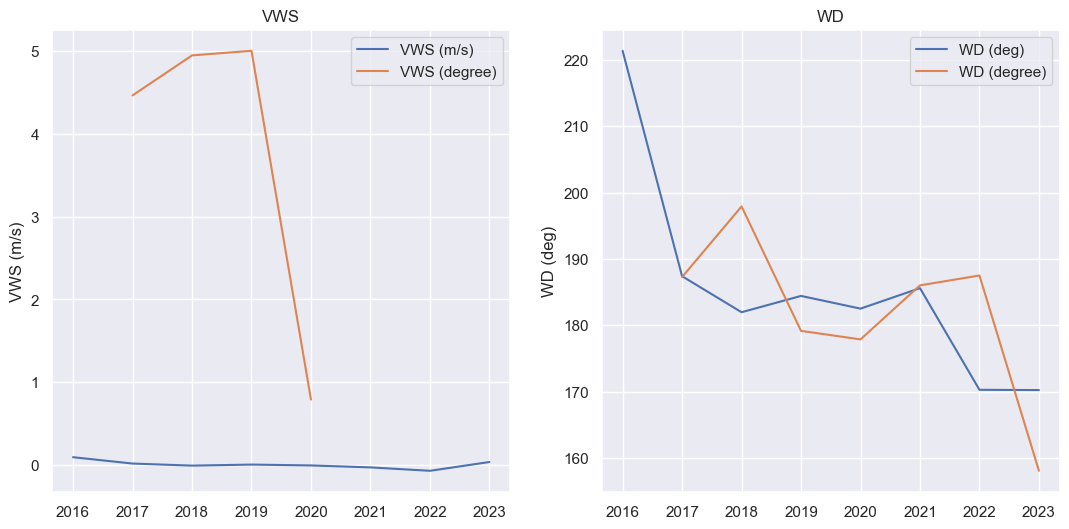

In [125]:
plot_features_similarities(df, truly_similar_names)

$\textbf{Exploratory Data Analysis (EDA)}$